# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [1]:
import numpy as np
import random
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
# coordinates
x = df['x'].to_numpy() 
y = df['y'].to_numpy() 
# signal to noise ratio
SNR = df['SNR'].to_numpy()

print(df.head())

           x          y        SNR
0  40.238833   4.265986  10.175131
1  98.283520  37.818614   3.825913
2  40.218399  70.433962   7.657508
3  62.067195  72.951305   4.979963
4  15.436981  22.427707  11.729007


## Helper functions

These functions will help us evaluate the results

In [15]:
def compute_distance(x, y):
    # Compute the Euclidean distance from the origin
    distance = np.sqrt(x**2+y**2)
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)

def predict(distance, poly_coeffs):
    # Predict the SNR from a given model
    SNR = 0
    for i, j in enumerate(np.flip(poly_coeffs)):
        SNR += j*distance**i
    return SNR

def evaluate(distance, SNR, poly_coeffs):
    # Compute the error of the polynomial fit on the chosen data
    SNR_predicted = predict(distance, poly_coeffs)
    mse = np.sum((SNR - SNR_predicted)**2)/len(SNR)
    return mse

def separate_test(distance, SNR, test_points):
    # Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly

    idx = list(range(len(SNR)))

    test_idx = random.sample(idx, test_points)
    train_idx = [i for i in idx if i not in test_idx]
    
    x_train = distance[train_idx]
    x_test = distance[test_idx]
    y_train = SNR[train_idx]
    y_test = SNR[test_idx]

    return x_train, y_train, x_test, y_test

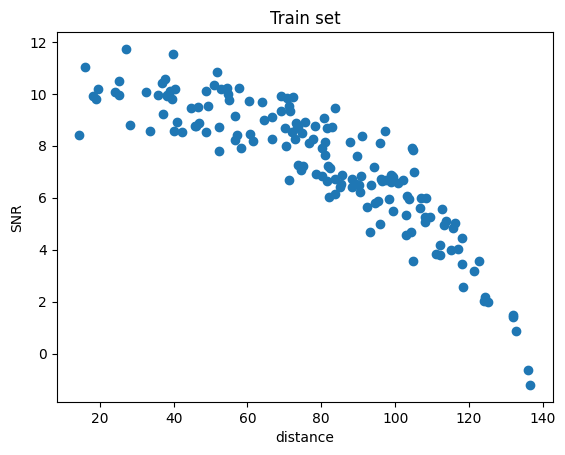

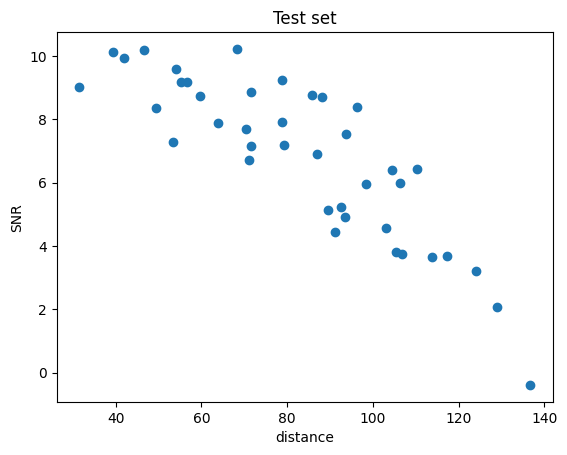

In [16]:
# separate the training and test sets and create a scatter plot of the SNR as a function of the distance
distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, 40)

plt.scatter(x_train, y_train)
plt.title("Train set")
plt.xlabel("distance")
plt.ylabel("SNR")
plt.show()

plt.scatter(x_test, y_test)
plt.title("Test set")
plt.xlabel("distance")
plt.ylabel("SNR")
plt.show()

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [17]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # The two returned values are the best degree and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR

    best = -1
    best_perf = 1e20
    results = []
    
    # Divide training set in K folds
    x_folds = []
    y_folds = []
    fold_points = int(np.floor(len(x_train) / k))
    idx = list(range(len(x_train)))
    for i in range(k):
        fold_idx = random.sample(idx, fold_points)
        idx = [i for i in idx if i not in fold_idx]
        x_folds.append(x_train[fold_idx])
        y_folds.append(y_train[fold_idx])
    # Train and validate
    for deg in range(max_degree + 1):
        degree_perf = 0
        for test in range(k):
            x_train_fold = [x for i, x in enumerate(x_folds) if i != test] 
            y_train_fold = [x for i, x in enumerate(y_folds) if i != test]
            x_train_fold = np.concatenate(x_train_fold)
            y_train_fold = np.concatenate(y_train_fold)
            x_validate_fold = x_folds[test]
            y_validate_fold = y_folds[test]
            k_model = fit(x_train_fold, y_train_fold, deg)
            degree_perf += evaluate(x_validate_fold, y_validate_fold, k_model)
        degree_perf /= k
        results.append(degree_perf)
        if (best_perf > degree_perf):
            best = fit(x_train, y_train, deg)
            best_perf = degree_perf
        
    return best, results

[-1.37151718e-07  3.47176157e-05 -3.60905015e-03  1.27713904e-01
  8.51987537e+00]


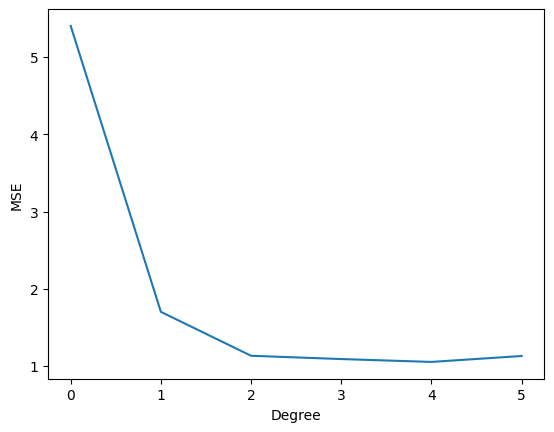

In [20]:
# run the training with K-fold cross-validation with 40 test points and 4 folds Plot the validation score as a function of the degree
K = 4
max_degree = 5

distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, 40)
best_model_kfold, results = k_fold_cross_validation(x_train, y_train, K, max_degree)
print(best_model_kfold)

plt.plot(range(max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('MSE')
plt.show()

[-1.37151718e-07  3.47176157e-05 -3.60905015e-03  1.27713904e-01
  8.51987537e+00] 0.5735329769983798


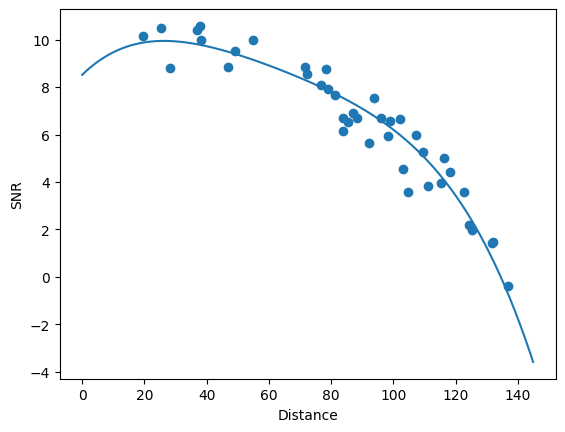

In [22]:
# get the test performance of the best model and plot the model output and test points. 
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?
values = np.arange(0, 145, 0.1)
predicted_SNR = predict(values, best_model_kfold)

print(best_model_kfold, evaluate(x_test, y_test, best_model_kfold))

plt.plot(values, predicted_SNR)
plt.scatter(x_test, y_test)
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.show()

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01/0.02$)

In [8]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # apply Tikhonov regularization AFTER the fitting process

    # Define initial parameters
    best = None
    best_error = float("inf")
    results = []

    # Iterate over polinomial degrees
    for deg in range(max_degree + 1):
        # Define the model
        k_model = np.polyfit(x_train, y_train, deg)

        # Compute the loss
        loss = evaluate(x_train, y_train, k_model) # Empirical risk
        loss += np.sum(k_model ** 2) * lambda_par
        results.append(loss)

        # Update the best model if this degree has the lowest error
        if (best_error > loss):
            best_error = loss
            best = k_model

    return best, results

[ 7.08499284e-10 -3.71611185e-07  6.63878629e-05 -5.88436704e-03
  2.12972957e-01  7.26934551e+00]


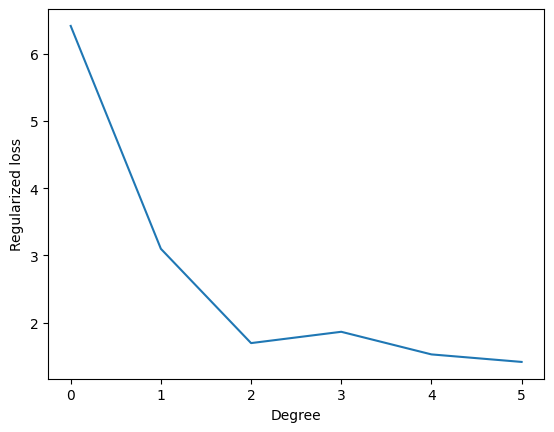

In [9]:
# run the training with Tikhonov regularization and plot the loss as a function of the degree

lambda_par = 0.01
max_degree = 5

best_model_tikonhov, results = evaluate_tikhonov(x_train, y_train, lambda_par, max_degree)
print(best_model_tikonhov)

plt.plot(range(max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('Regularized loss')
plt.show()

## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [10]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # apply Tikhonov regularization AFTER the fitting process

    # Define initial parameters
    best = None
    best_error = float("inf")
    results = []

    for deg in range(max_degree + 1):
        k_model = np.polyfit(x_train, y_train, deg)

        loss = evaluate(x_train, y_train, k_model) # Empirical risk
        loss += np.power(2, deg + 1) * lambda_par
        results.append(loss)
        
        if (best_error > loss):
            best_error = loss
            best = k_model

    return best, results

[-8.16212477e-04  5.16862577e-02  8.90333767e+00]


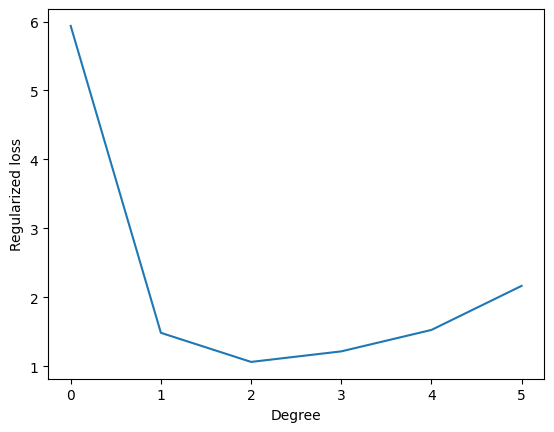

In [11]:
# run the training with MDL regularization and plot the loss as a function of the degree

lambda_par = 0.02
max_degree = 5

best_model_representation, results = evaluate_representation(x_train, y_train, lambda_par, max_degree)
print(best_model_representation)

plt.plot(range(max_degree + 1), results)
plt.xlabel('Degree')
plt.ylabel('Regularized loss')
plt.show()


### TEST

Check the performance of the three solutions on the test set: which one does best?


[-1.37151718e-07  3.47176157e-05 -3.60905015e-03  1.27713904e-01
  8.51987537e+00]


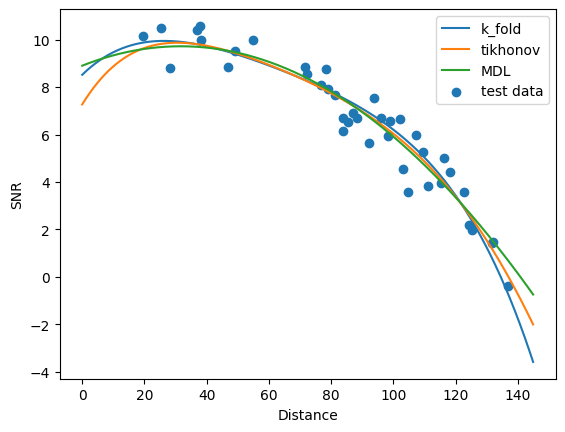

In [21]:
# plot the results

values = np.arange(0, 145, 0.1)

pred_SNR_kfold = predict(values, best_model_kfold)
pred_SNR_tkh = predict(values, best_model_tikonhov)
pred_SNR_MDL = predict(values, best_model_representation)

plt.plot(values, pred_SNR_kfold, label="k_fold")
plt.plot(values, pred_SNR_tkh, label="tikhonov")
plt.plot(values, pred_SNR_MDL, label="MDL")

plt.scatter(x_test, y_test, label="test data")
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.legend()
plt.show()